In [12]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [13]:
seq_len = 7
data_dim = 5
hidden_dim = 30
output_dim = 1
learning_rate = 0.001

epochs = 150

In [14]:
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")

In [39]:
xy = xy[::-1]
# plt.plot(xy)
# plt.show()

In [40]:
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size-seq_len : ]

train_set.shape, test_set.shape

print(train_set[:5])

[[   568.00257     568.00257     552.922516  13100.          558.462551]
 [   561.202549    566.43259     558.672539  41200.          559.992565]
 [   566.892592    567.002574    556.932537  10800.          556.972503]
 [   558.712504    568.452595    558.712504   7900.          567.162558]
 [   599.992707    604.832763    562.192568 147100.          567.002574]]


In [50]:
scaler = MinMaxScaler()
scaler.fit(train_set)
train_set = scaler.transform(train_set)

train_set.shape

(512, 5)

In [42]:
scaler.fit(test_set)
test_set = scaler.transform(test_set)


In [43]:
def build_dataset(time_series, seq_len):
    dataX = []
    dataY = []
    
    for i in range(len(time_series)-seq_len):
        _x = time_series[i:i+seq_len, :]
        _y = time_series[i+seq_len, [-1]]
        
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [44]:
train_x, train_y = build_dataset(train_set, seq_len)
test_x, test_y = build_dataset(test_set, seq_len)

print("train_x.shape : {}".format(train_x.shape))
print("train_y.shape : {}".format(train_y.shape))

train_x.shape : (505, 7, 5)
train_y.shape : (505, 1)


In [45]:
train_x_tensor = torch.FloatTensor(train_x)
train_y_tensor = torch.FloatTensor(train_y)

test_x_tensor = torch.FloatTensor(test_x)
test_y_tensor = torch.FloatTensor(test_y)

In [46]:
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(LSTM,self).__init__()
        
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True, bidirectional=True)
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim*2, 20),
            torch.nn.Linear(20, 10),
            torch.nn.Linear(10,output_dim)
        )
    
    def forward(self, x):
        x, (hidden, cell) = self.lstm(x)
        x = self.layers(x[:, -1, ])
        return x

In [47]:
model = LSTM(data_dim, hidden_dim, output_dim, 4)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(train_x_tensor)
    loss = criterion(outputs, train_y_tensor)
    
    loss.backward()
    optimizer.step()
    
    if i%25 == 0:
        print('Epoch {}, Loss {:.5f}'.format(i, loss.item()))

Epoch 0, Loss 0.09718
Epoch 25, Loss 0.04778
Epoch 50, Loss 0.00673
Epoch 75, Loss 0.00421
Epoch 100, Loss 0.00351
Epoch 125, Loss 0.00309


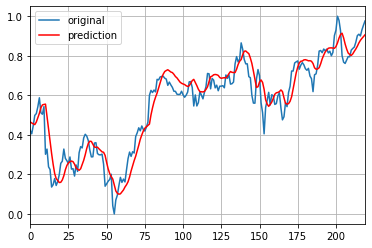

In [49]:
model.eval()

with torch.no_grad():
    predict_data = model(test_x_tensor).data.numpy()
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(test_y)
    plt.plot(predict_data, color='red')
    plt.legend(['original', 'prediction'])
    plt.show()